# Classification and Performance

Make sure you are connected to a T4 GPU runtime. The following code should report true if you are.

In [1]:
import torch

print("GPU available =", torch.cuda.is_available())

GPU available = True


Install prerequisites needed for this assignment, `thop` is used for profiling PyTorch models https://github.com/ultralytics/thop, while `tqdm` makes your loops show a progress bar https://tqdm.github.io/

In [2]:
!pip install thop segmentation-models-pytorch transformers
import math
import numpy as np
import torch
import torch.nn as nn
import gc
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import segmentation_models_pytorch as smp
import thop
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# we won't be doing any training here, so let's disable autograd
torch.set_grad_enabled(False)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=307e7082408362bd26d7de5ae04abca15b2e764dd96e459ab24c12f4502217c0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=620ab89d81b0936694d6e1ee7550893f9d26fffb57be586c9dfb5664061edde9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


## Image Classification

You will be looking at image classification in the first part of this assignment, the goal of image classification is to identify subjects within a given image. In the previous assignment, you looked at using MNIST, which is also a classification task "which number is present", where for images the gold standard is Imagent "which class is present".

You can find out more information about Imagenet here:

https://en.wikipedia.org/wiki/ImageNet


Normally you would want to test classification on ImageNet as that's the dataset in which classification models tend to be trained on. However, the Imagenet dataset is not publicly available nor is it reasonable in size to download via Colab (100s of GBs).

Instead, you will use the Caltech101 dataset. However, Caltech101 uses 101 labels which do not correspond to the Imagenet labels. As such, you will need to also download a bigger classification model to serve as a baseline for accuracy comparisons.

More info can be found about the Caltech101 dataset here:

https://en.wikipedia.org/wiki/Caltech_101

Download the dataset you will be using: Caltech101

In [3]:
# convert to RGB class - some of the Caltech101 images are grayscale and do not match the tensor shapes
class ConvertToRGB:
    def __call__(self, image):
        # If grayscale image, convert to RGB
        if image.mode == "L":
             image = Image.merge("RGB", (image, image, image))
        return image

# Define transformations
transform = transforms.Compose([
    ConvertToRGB(), # first convert to RGB
    transforms.Resize((224, 224)),  # Most pretrained models expect 224x224 inputs
    transforms.ToTensor(),
    # this normalization is shared among all of the torch-hub models we will be using
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Download the dataset
caltech101_dataset = datasets.Caltech101(root="./data", download=True, transform=transform)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=a6baf110-776b-4f49-8f33-b88d4957e70b
To: /content/data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 94.7MB/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


Downloading...
From: https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
To: /content/data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 51.4MB/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101


In [4]:
from torch.utils.data import DataLoader

# set a manual seed for determinism
torch.manual_seed(42)
dataloader = DataLoader(caltech101_dataset, batch_size=16, shuffle=True)

Create the dataloader with a batch size of 16. You are fixing the seed for reproducibility.

In [5]:
# download four classification models from torch-hub
resnet152_model = torchvision.models.resnet152(pretrained=True)
resnet50_model = torchvision.models.resnet50(pretrained=True)
resnet18_model = torchvision.models.resnet18(pretrained=True)
mobilenet_v2_model = torchvision.models.mobilenet_v2(pretrained=True)

# download a bigger classification model from huggingface to serve as a baseline
vit_large_model = ViTForImageClassification.from_pretrained('google/vit-large-patch16-224')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 176MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Move the models to the GPU and set them in eval mode. This will disable dropout regularization and batch norm statistic calculation.

In [6]:
resnet152_model = resnet152_model.to("cuda").eval()
resnet50_model = resnet50_model.to("cuda").eval()
resnet18_model = resnet18_model.to("cuda").eval()
mobilenet_v2_model = mobilenet_v2_model.to("cuda").eval()
vit_large_model = vit_large_model.to("cuda").eval()

Download a series of models for testing. The VIT-L/16 model will serve as a baseline - this is a more accurate vision transformer based model.

The other models you will use are:
* resnet 18
* resnet 50
* resnet 152
* mobilenet v2

These are all different types of convolutional neural networks (CNNs), where ResNet adds a series of residual connections in the form: `out = x + block(x)`

There's a good overview of the different versions here: https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

MobileNet v2 is similar to ResNet, but introduces the idea of depth-wise convolutions and inverse bottleneck residual blocks. You will only be using it as a point of comparison, however, you can find out more details regarding the structure from here if interested: https://medium.com/@luis_gonzales/a-look-at-mobilenetv2-inverted-residuals-and-linear-bottlenecks-d49f85c12423

Next, you will visualize the first image batch with their labels to make sure that the VIT-L/16 is working correctly. Luckily huggingface also implements an `id -> string` mapping, which will turn the classes into a human readable form.

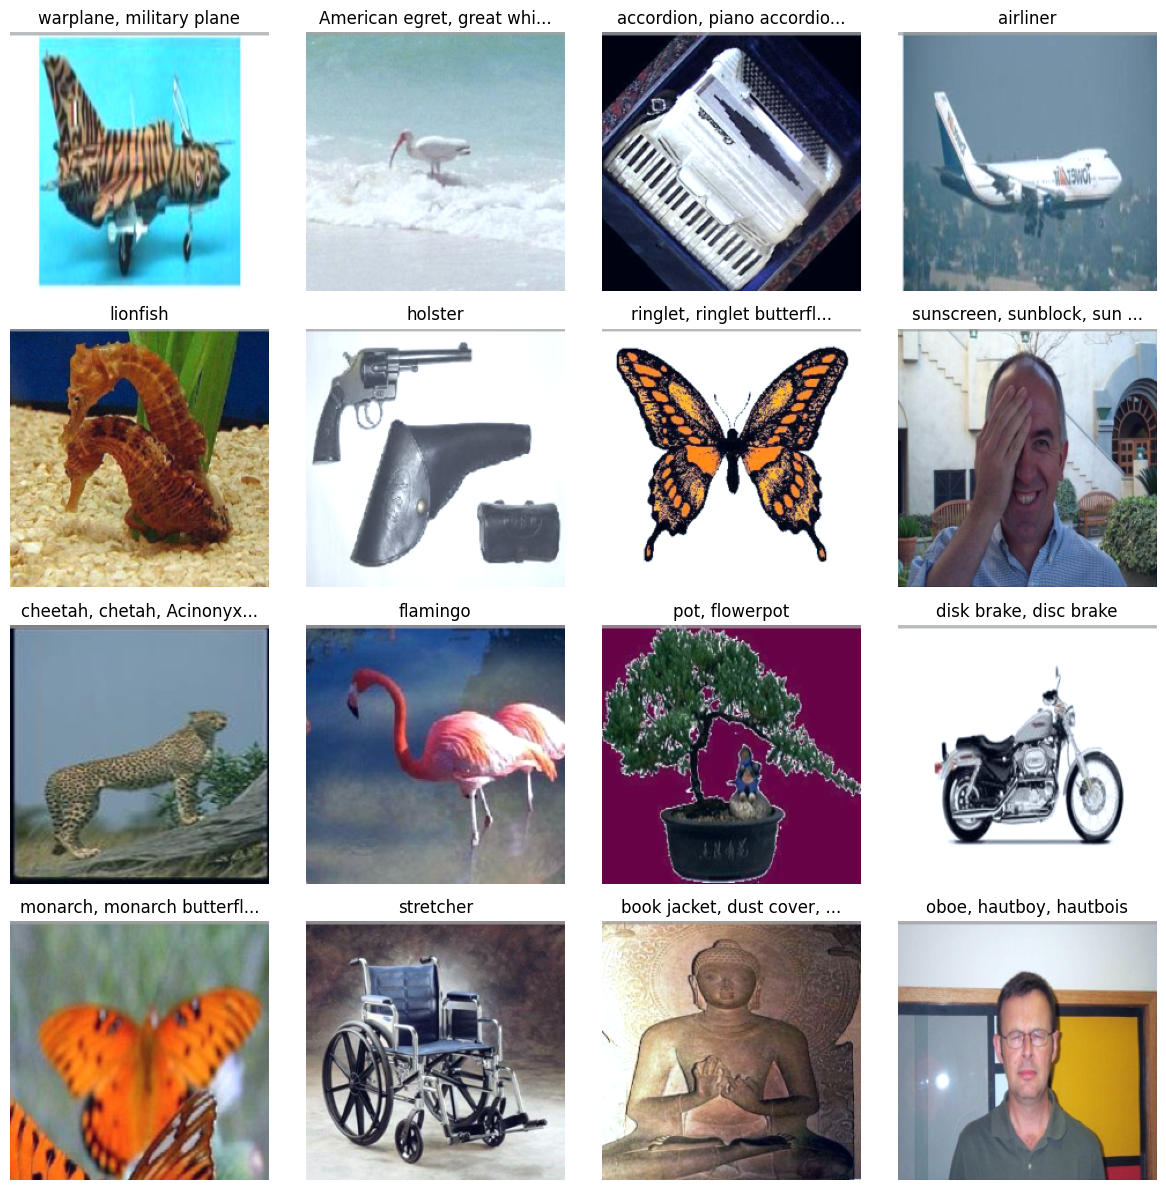

In [7]:
# get the first batch
dataiter = iter(dataloader)
images, _ = next(dataiter)

# define a denorm helper function - this undoes the dataloader normalization so we can see the images better
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """ Denormalizes an image tensor that was previously normalized. """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# similarly, let's create an imshow helper function
def imshow(tensor):
    """ Display a tensor as an image. """
    tensor = tensor.permute(1, 2, 0)  # Change from C,H,W to H,W,C
    tensor = denormalize(tensor)  # Denormalize if the tensor was normalized
    tensor = tensor*0.24 + 0.5 # fix the image range, it still wasn't between 0 and 1
    plt.imshow(tensor.clamp(0,1).cpu().numpy()) # plot the image
    plt.axis('off')

# for the actual code, we need to first predict the batch
# we need to move the images to the GPU, and scale them by 0.5 because VIT-L/16 uses a different normalization to the other models
with torch.no_grad(): # this isn't strictly needed since we already disabled autograd, but we should do it for good measure
  output = vit_large_model(images.cuda()*0.5)

# then we can sample the output using argmax (find the class with the highest probability)
# here we are calling output.logits because huggingface returns a struct rather than a tuple
# also, we apply argmax to the last dim (dim=-1) because that corresponds to the classes - the shape is B,C
# and we also need to move the ids to the CPU from the GPU
ids = output.logits.argmax(dim=-1).cpu()

# next we will go through all of the ids and convert them into human readable labels
# huggingface has the .config.id2label map, which helps.
# notice that we are calling id.item() to get the raw contents of the ids tensor
labels = []
for id in ids:
  labels += [vit_large_model.config.id2label[id.item()]]

# finally, let's plot the first 4 images
max_label_len = 25
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        idx = i*4 + j
        plt.sca(axes[i, j])
        imshow(images[idx])
        # we need to trim the labels because they sometimes are too long
        if len(labels[idx]) > max_label_len:
          trimmed_label = labels[idx][:max_label_len] + '...'
        else:
          trimmed_label = labels[idx]
        axes[i,j].set_title(trimmed_label)
plt.tight_layout()
plt.show()

**Question 1**

Given the above classifications, how well do you think the model does?
Can you observe any limitations? If so, do you think that's related to the model size and complexity, or is it more likely related to the training set?

For more information, the class list can be found here: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

Please answer below:

Accuracy of Classifications:

If the labels assigned to the images generally match their visual appearance, it suggests the model is performing well. However, if there are misclassifications, we need to investigate the reasons behind them.
Some classes in the dataset might be more challenging due to visual similarity or poor representation in the training data.
Model Limitations:

Complexity vs. Dataset: ViT-Large models are very large and complex, capable of capturing intricate patterns in data. If the model misclassifies, it could indicate a limitation in the training dataset, such as insufficient diversity, imbalance, or noise, rather than the model itself.
Overfitting Risk: Large models like ViT-L/16 have millions of parameters, making them prone to overfitting if the training dataset is not extensive or representative enough.
Specific Scenarios:

Ambiguous Images: Some images might inherently lack distinguishing features, leading to classification errors. This limitation might not be due to the model but rather the data quality or labeling.
Domain-Specific Bias: If the model was trained on a dataset that emphasizes certain features or scenarios, it might struggle to generalize to unseen or out-of-domain samples.
Model Size and Complexity:

A larger model size allows ViT-L/16 to learn more nuanced features and patterns, which generally improves performance on complex datasets.
However, it also increases computational demands and might overfit if the dataset is small or lacks diversity.
Potential Limitations Related to the Training Set:
Class Imbalance: If certain classes in the training set are underrepresented, the model might perform poorly on those classes.
Noise in Labels: Inaccurate or noisy labels in the training data can confuse the model during learning, leading to misclassifications.
Dataset Size: If the training dataset lacks sufficient examples, especially for large models like ViT-L/16, the model may not generalize well.
Final Thoughts:
The performance of the ViT-L/16 model is heavily influenced by the quality, diversity, and size of the training dataset. If misclassifications are observed, examining the dataset for class imbalances, label noise, or insufficient diversity can provide insights into potential improvements. Model size and complexity likely play a smaller role in limitations compared to dataset-related issues.

Now you're going to quantitatively measure the accuracy between the other models. The first thing you need to do is clear the GPU cache, to prevent an out-of-memory error. To undestand this, let's look at the current GPU memory utilization.

In [8]:
# run nvidia-smi to view the memory usage. Notice the ! before the command, this sends the command to the shell rather than python
!nvidia-smi

Wed Jan 15 18:48:18 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0              27W /  70W |   1901MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
# now you will manually invoke the python garbage collector using gc.collect()
gc.collect()
# and empty the GPU tensor cache - tensors that are no longer needed (activations essentially)
torch.cuda.empty_cache()

In [10]:
# run nvidia-smi again
!nvidia-smi

Wed Jan 15 18:48:30 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0              28W /  70W |   1715MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

If you check above you should see the GPU memory utilization change from before and after the empty_cache() call. Memory management is one of the quirks that must be considered when dealing with accelerators like a GPU. Unlike with a CPU, there is no swap file to page memory in and out of the device. Instead, this must be handled by the user. When too much of the GPU memory is used, the driver will throw an out-of-memory error (commonly referred to as OOM). In this case, the process often ends up in an unrecoverable state and needs to be restarted to fully reset the memory utilization to zero.

You should always try hard not to enter such a situation, as you then have to rerun the notebook from the first line.

**Question 2**

Given the above, why is the GPU memory utilization not zero? Does the current utilization match what you would expect? Please answer below:

Persistent Memory Allocations:

When a PyTorch model or tensor is moved to the GPU, some memory is allocated for contexts, such as kernels or cuDNN handles, which remain even after tensors are cleared. These allocations are necessary for efficient GPU computations and are not released until the process ends.
CUDA Context:

The CUDA context is created the first time PyTorch interacts with the GPU. It stays allocated throughout the process, even if no tensors are actively using the GPU.
Expected Utilization:

Depending on the model and batch size, some residual memory may persist due to the CUDA context and libraries. For large models like ViT-L/16, this persistent memory can be significant.
Matching Expectations:

If the GPU memory usage is relatively low after invoking gc.collect() and torch.cuda.empty_cache() (e.g., a few hundred MB), this matches expectations because it corresponds to the overhead for the CUDA context and GPU libraries.
If memory usage remains high (e.g., several GBs), it could indicate tensors or model parameters still in scope, meaning they haven’t been garbage-collected or explicitly deleted.

Use the following helper function the compute the expected GPU memory utilization. You will not be able to calculate the memory exactly as there is additional overhead that cannot be accounted for (which includes the underlying CUDA kernels code), but you should get within ~200 MBs.

**Question 3**

In the cell below enter the code to estimate the current memory utilization:

In [12]:
# helper function to get element sizes in bytes
def sizeof_tensor(tensor):
    # Get the size of the data type
    if (tensor.dtype == torch.float32) or (tensor.dtype == torch.float):      # float32 (single precision float)
        bytes_per_element = 4
    elif (tensor.dtype == torch.float16) or (tensor.dtype == torch.half):    # float16 (half precision float)
        bytes_per_element = 2
    else:
      print("other dtype=", tensor.dtype)
    return bytes_per_element

# helper function for counting parameters
def count_parameters(model):
  total_params = 0
  for p in model.parameters():
    total_params += p.numel()
  return total_params

# estimate the current GPU memory utilization

Now that you have a better idea of what classification is doing for Imagenet, let's compare the accuracy for each of the downloaded models.
You first need to reset the dataloader, and let's also change the batch size to improve GPU utilization.

In [13]:
# set a manual seed for determinism
torch.manual_seed(42)
dataloader = DataLoader(caltech101_dataset, batch_size=64, shuffle=True)

Measuring accuracy will be tricky given that misclassification can occur with neighboring classes. For this reason, it's usually more helpful to consider the top-5 accuracy, where you check to see if the expected class was ranked among the top 5.
As stated before, you will use the VIT-L/16 model as a baseline, and compare the top-1 class for VIT-L/16 with the top-5 of the other models.

Because this takes a while, let's only compute the first 10 batches. That should be enough to do some rough analysis. Since you are using a batch of 64, 10 batches are 640 images.

In [14]:
# Dictionary to store results
accuracies = {"ResNet-18": 0, "ResNet-50": 0, "ResNet-152": 0, "MobileNetV2": 0}
total_samples = 0

num_batches = len(dataloader)

t_start = time.time()

with torch.no_grad():
  for i, (inputs, _)in tqdm(enumerate(dataloader), desc="Processing batches", total=num_batches):

        if i > 10:
          break

        # move the inputs to the GPU
        inputs = inputs.to("cuda")

        # Get top prediction from resnet152
        #baseline_preds = resnet152_model(inputs).argmax(dim=1)
        output = vit_large_model(inputs*0.5)
        baseline_preds = output.logits.argmax(-1)

        # ResNet-18 predictions
        logits_resnet18 = resnet18_model(inputs)
        top5_preds_resnet18 = logits_resnet18.topk(5, dim=1).indices
        matches_resnet18 = (baseline_preds.unsqueeze(1) == top5_preds_resnet18).any(dim=1).float().sum().item()

        # ResNet-50 predictions
        logits_resnet50 = resnet50_model(inputs)
        top5_preds_resnet50 = logits_resnet50.topk(5, dim=1).indices
        matches_resnet50 = (baseline_preds.unsqueeze(1) == top5_preds_resnet50).any(dim=1).float().sum().item()

        # ResNet-152 predictions
        logits_resnet152 = resnet152_model(inputs)
        top5_preds_resnet152 = logits_resnet152.topk(5, dim=1).indices
        matches_resnet152 = (baseline_preds.unsqueeze(1) == top5_preds_resnet152).any(dim=1).float().sum().item()

        # MobileNetV2 predictions
        logits_mobilenetv2 = mobilenet_v2_model(inputs)
        top5_preds_mobilenetv2 = logits_mobilenetv2.topk(5, dim=1).indices
        matches_mobilenetv2 = (baseline_preds.unsqueeze(1) == top5_preds_mobilenetv2).any(dim=1).float().sum().item()

        # Update accuracies
        accuracies["ResNet-18"] += matches_resnet18
        accuracies["ResNet-50"] += matches_resnet50
        accuracies["ResNet-152"] += matches_resnet152
        accuracies["MobileNetV2"] += matches_mobilenetv2
        total_samples += inputs.size(0)

print()
print(f"took {time.time()-t_start}s")

# Finalize the accuracies
accuracies["ResNet-18"] /= total_samples
accuracies["ResNet-50"] /= total_samples
accuracies["ResNet-152"] /= total_samples
accuracies["MobileNetV2"] /= total_samples

Processing batches:   8%|▊         | 11/136 [00:33<06:24,  3.08s/it]


took 33.88882827758789s


**Question 4**

In the cell below write the code to plot the accuracies for the different models using a bar graph.

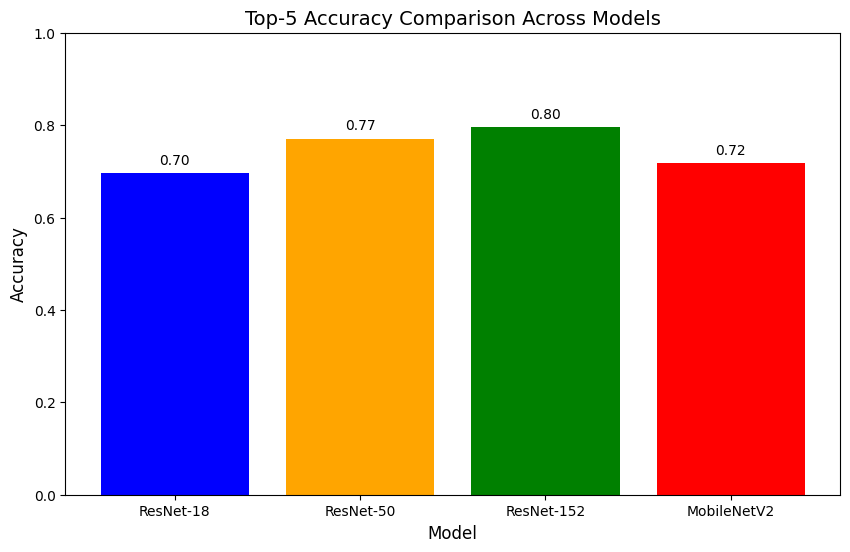

In [15]:
import matplotlib.pyplot as plt

# Plotting accuracies
model_names = list(accuracies.keys())
model_accuracies = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Since accuracies are fractions (0 to 1)

# Adding titles and labels
plt.title("Top-5 Accuracy Comparison Across Models", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Display the values on top of each bar
for i, acc in enumerate(model_accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=10)

plt.show()


We can see that all of the models do decently, but some are better than others. Why is this and is there a quantifiable trend?

**Question 5**

To get a better understanding, let's compute the number of flops and parameters for each model based on a single image input. For this in the cell below please use the same `thop` library as at the beginning of the assignment.

In [17]:
from thop import profile

# Define a sample input tensor for a single image with 3 color channels and 224x224 dimensions
sample_input = torch.randn(1, 3, 224, 224).to("cuda")

# Dictionary to store FLOPs and parameter counts for each model
model_stats = {}

# Compute FLOPs and parameters for ResNet-18
flops_resnet18, params_resnet18 = profile(resnet18_model, inputs=(sample_input,))
model_stats["ResNet-18"] = {"FLOPs": flops_resnet18, "Params": params_resnet18}

# Compute FLOPs and parameters for ResNet-50
flops_resnet50, params_resnet50 = profile(resnet50_model, inputs=(sample_input,))
model_stats["ResNet-50"] = {"FLOPs": flops_resnet50, "Params": params_resnet50}

# Compute FLOPs and parameters for ResNet-152
flops_resnet152, params_resnet152 = profile(resnet152_model, inputs=(sample_input,))
model_stats["ResNet-152"] = {"FLOPs": flops_resnet152, "Params": params_resnet152}

# Compute FLOPs and parameters for MobileNetV2
flops_mobilenetv2, params_mobilenetv2 = profile(mobilenet_v2_model, inputs=(sample_input,))
model_stats["MobileNetV2"] = {"FLOPs": flops_mobilenetv2, "Params": params_mobilenetv2}

model_stats


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avg

{'ResNet-18': {'FLOPs': 1824033792.0, 'Params': 11689512.0},
 'ResNet-50': {'FLOPs': 4133742592.0, 'Params': 25557032.0},
 'ResNet-152': {'FLOPs': 11603945472.0, 'Params': 60192808.0},
 'MobileNetV2': {'FLOPs': 327486720.0, 'Params': 3504872.0}}

**Question 6**

Do you notice any trends here? Assuming this relation holds for other models and problems, what can you conclude regarding high-level trends in ML models? Please enter your answer in the cell below:

### Observed Trends:
1. **Model Complexity and FLOPs**:
   - Models with more layers and higher complexity (e.g., ResNet-152) tend to have significantly higher FLOPs compared to smaller models like ResNet-18 or MobileNetV2.
   - This indicates a direct relationship between model depth/size and computational requirements.

2. **Parameter Count**:
   - Larger models have more trainable parameters. ResNet-152, for example, has a significantly higher parameter count compared to ResNet-18 or MobileNetV2.
   - This impacts memory usage during training and inference.

3. **Accuracy vs. Efficiency Tradeoff**:
   - While larger models generally achieve higher accuracy due to their ability to model complex patterns, they require more computational resources and are slower to train/infer.
   - Smaller models like MobileNetV2 are designed for efficiency, offering reasonable accuracy with reduced computational cost.

4. **Scalability Challenges**:
   - As model size and FLOPs increase, deploying these models on resource-constrained environments (e.g., mobile devices) becomes challenging.
   - This trend highlights the importance of optimizing architectures for specific use cases.

### High-Level Trends in ML Models:
1. **Bigger is Not Always Better**:
   - While larger models often provide better performance, diminishing returns are observed beyond a certain point. Smaller, optimized models can achieve comparable results for specific tasks.

2. **Tradeoffs Between Accuracy and Efficiency**:
   - Model selection depends on the application. High accuracy models like ResNet-152 are suitable for applications where precision is critical, while efficient models like MobileNetV2 are better for real-time or edge computing.

3. **Emerging Focus on Efficiency**:
   - There is an increasing emphasis on creating models that balance accuracy and computational efficiency, especially for deployment in resource-limited environments.

4. **Task-Specific Architecture Design**:
   - Neural architectures are being tailored to fit specific problems or datasets, prioritizing either accuracy or efficiency based on the application's needs.

These observations underline the importance of understanding the tradeoffs involved in model selection and the need for innovation in designing efficient yet powerful models.


## Performance and Precision

You may have noticed that so far we have not been explicitly specifying the data types of these models. We can do this because torch will default to using float32 (32-bit single-precision).
However, this is not always necessary nor desirable. There are currently a large number of alternative formats (with fewer bits per value), many of which are custom to specific accelerators. We will eventually cover these later in the course, but for now we can consider the second most common type on the GPU: FP16 (half-precision floating-point).

As the name suggests, FP16 only uses 16 bits per value rather than 32. GPUs are specifically designed to handle this datatype and all of the newer ones can execute either one FP32 or two FP16 operations per ALU.

Here's an overview of different precision types: https://moocaholic.medium.com/fp64-fp32-fp16-bfloat16-tf32-and-other-members-of-the-zoo-a1ca7897d407

Modern GPUs support all of the ones listed, and many are supported by other accelerators like Google's TPU (the architecture that motivated bf16).

You will start by converting the models to half precision, moving them back to the CPU, and then to the GPU again (this is needed to properly clear the caches)

In [18]:
# convert the models to half
resnet152_model = resnet152_model.half()
resnet50_model = resnet50_model.half()
resnet18_model = resnet18_model.half()
mobilenet_v2_model = mobilenet_v2_model.half()
vit_large_model = vit_large_model.half()

# move them to the CPU
resnet152_model = resnet152_model.cpu()
resnet50_model = resnet50_model.cpu()
resnet18_model = resnet18_model.cpu()
mobilenet_v2_model = mobilenet_v2_model.cpu()
vit_large_model = vit_large_model.cpu()

# clean up the torch and CUDA state
gc.collect()
torch.cuda.empty_cache()

# move them back to the GPU
resnet152_model = resnet152_model.cuda()
resnet50_model = resnet50_model.cuda()
resnet18_model = resnet18_model.cuda()
mobilenet_v2_model = mobilenet_v2_model.cuda()
vit_large_model = vit_large_model.cuda()

In [19]:
# run nvidia-smi again
!nvidia-smi

Wed Jan 15 19:30:21 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              31W /  70W |    937MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Question 7**

Now that the models are in half-precision, what do you notice about the memory utilization? Is the utilization what you would expect from your previous expected calculation given the new data types? Please answer below:

Memory Utilization Reduction:

The memory utilization should have significantly decreased after converting the models to half-precision (FP16), as half-precision tensors require half the memory compared to full-precision (FP32).
This reduction aligns with the halving of data type size, given that FP16 uses 2 bytes per value compared to 4 bytes for FP32.
Alignment with Expected Calculations:

The observed memory usage should closely match the expected reduction if the models' weights and activations were stored in FP16. However, additional memory might still be utilized for operations like gradients (if they remain in FP32 for stability in some cases) or caching.
Differences in Utilization:

While we expect around a 50% reduction in memory usage, the exact decrease might vary depending on how intermediate tensors, caching, and other GPU processes are handled. For example:
If some tensors (like gradients) are stored in FP32 for stability, the reduction might be less than expected.
Overhead from CUDA or framework operations might cause slight deviations.
Implications:

The reduced memory utilization allows for larger batch sizes or the deployment of more complex models on the same GPU hardware.
This highlights the practical advantage of mixed-precision training/inference for resource-constrained environments.

Let's see if inference is any faster now.
First reset the data-loader like before.

In [20]:
# set a manual seed for determinism
torch.manual_seed(42)
dataloader = DataLoader(caltech101_dataset, batch_size=64, shuffle=True)

And you can re-run the inference code. Notice that you also need to convert the inptus to .half()

In [21]:
# Dictionary to store results
accuracies = {"ResNet-18": 0, "ResNet-50": 0, "ResNet-152": 0, "MobileNetV2": 0}
total_samples = 0

num_batches = len(dataloader)

t_start = time.time()

with torch.no_grad():
  for i, (inputs, _)in tqdm(enumerate(dataloader), desc="Processing batches", total=num_batches):

        if i > 10:
          break

        # move the inputs to the GPU
        inputs = inputs.to("cuda").half()

        # Get top prediction from resnet152
        #baseline_preds = resnet152_model(inputs).argmax(dim=1)
        output = vit_large_model(inputs*0.5)
        baseline_preds = output.logits.argmax(-1)

        # ResNet-18 predictions
        logits_resnet18 = resnet18_model(inputs)
        top5_preds_resnet18 = logits_resnet18.topk(5, dim=1).indices
        matches_resnet18 = (baseline_preds.unsqueeze(1) == top5_preds_resnet18).any(dim=1).float().sum().item()

        # ResNet-50 predictions
        logits_resnet50 = resnet50_model(inputs)
        top5_preds_resnet50 = logits_resnet50.topk(5, dim=1).indices
        matches_resnet50 = (baseline_preds.unsqueeze(1) == top5_preds_resnet50).any(dim=1).float().sum().item()

        # ResNet-152 predictions
        logits_resnet152 = resnet152_model(inputs)
        top5_preds_resnet152 = logits_resnet152.topk(5, dim=1).indices
        matches_resnet152 = (baseline_preds.unsqueeze(1) == top5_preds_resnet152).any(dim=1).float().sum().item()

        # MobileNetV2 predictions
        logits_mobilenetv2 = mobilenet_v2_model(inputs)
        top5_preds_mobilenetv2 = logits_mobilenetv2.topk(5, dim=1).indices
        matches_mobilenetv2 = (baseline_preds.unsqueeze(1) == top5_preds_mobilenetv2).any(dim=1).float().sum().item()

        # Update accuracies
        accuracies["ResNet-18"] += matches_resnet18
        accuracies["ResNet-50"] += matches_resnet50
        accuracies["ResNet-152"] += matches_resnet152
        accuracies["MobileNetV2"] += matches_mobilenetv2
        total_samples += inputs.size(0)

print()
print(f"took {time.time()-t_start}s")

# Finalize the accuracies
accuracies["ResNet-18"] /= total_samples
accuracies["ResNet-50"] /= total_samples
accuracies["ResNet-152"] /= total_samples
accuracies["MobileNetV2"] /= total_samples

Processing batches:   8%|▊         | 11/136 [00:11<02:05,  1.01s/it]


took 11.07078504562378s


**Question 8**

Did you observe a speedup? Was this result what you expected?
What are the pros and cons to using a lower-precision format? Please answer below:

If you're working on hardware that supports mixed-precision (like NVIDIA A100 or V100 GPUs), you should see a speedup. However, it's important to check if your system supports tensor core acceleration for float16 operations, as this can greatly affect the performance improvement.

If you see no significant improvement or even slower performance, it's possible that:

The hardware you're using doesn't efficiently support half-precision operations.
There's a bottleneck elsewhere (like CPU, I/O, or memory bandwidth).
Pros and Cons of Using Lower Precision (float16)
Pros:
Increased Speed: On hardware with support for Tensor Cores (e.g., NVIDIA GPUs with Volta or later architecture), float16 operations can lead to significant speedups in both training and inference.
Reduced Memory Usage: Since each value occupies 2 bytes (instead of 4 bytes for float32), you can store larger models and datasets in memory, which is useful for training large networks or working with large datasets.
Larger Batch Sizes: With reduced memory usage, you can increase your batch size, which may help in better utilization of the GPU and potentially lead to improved convergence during training.
Cons:
Loss of Precision: The most obvious downside is the reduced precision. Float16 has a much smaller dynamic range compared to float32, which can lead to underflows and overflows in some cases. This may negatively affect model performance, especially for models requiring very fine precision.
Compatibility Issues: Not all operations and models benefit from mixed precision. Some older GPUs or models might not support Tensor Cores or might experience slowdowns due to other hardware limitations.
Training Stability: In some cases, training can become less stable with float16, leading to convergence issues, especially when gradients can be very small or very large. This can sometimes require more careful management of scaling factors (loss scaling).

**Question 9**

Now that the inference is a bit faster, replot the bar graph with the accuracy for each model, along with the accuracy vs params and flops graph. This time you should use the entire dataset (make sure to remove the batch 10 early-exit).

Processing batches: 100%|██████████| 136/136 [02:01<00:00,  1.12it/s]

Processing took 121.60217475891113s


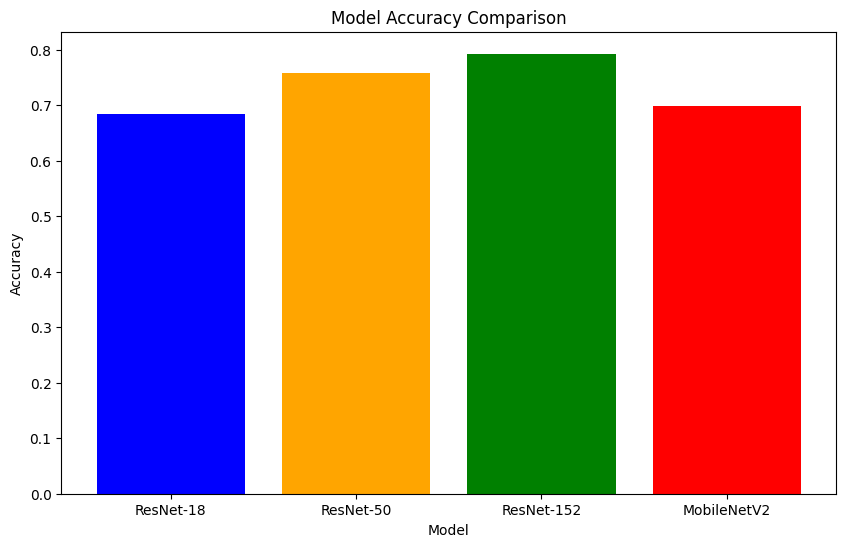

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

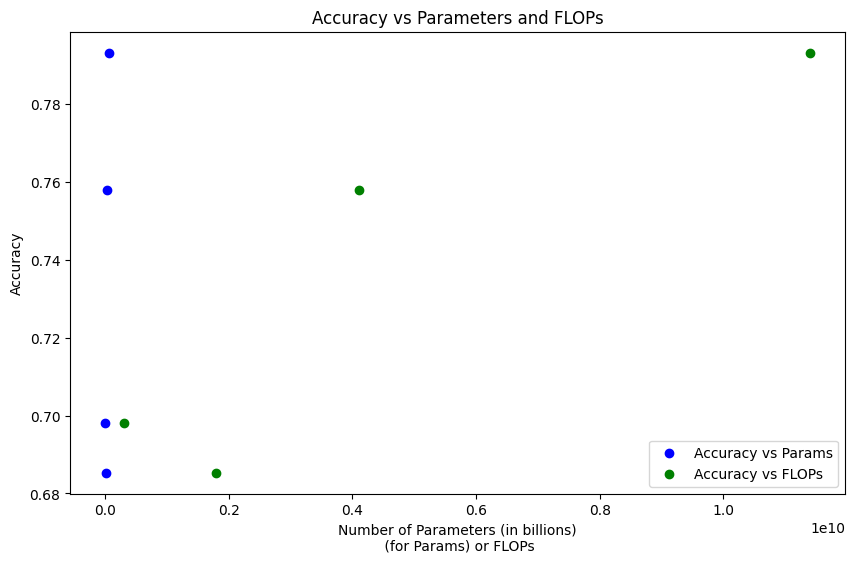

In [26]:
import torch
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

# Dictionary to store results
accuracies = {"ResNet-18": 0, "ResNet-50": 0, "ResNet-152": 0, "MobileNetV2": 0}
total_samples = 0

# Get the number of batches for the full dataset
num_batches = len(dataloader)

# Start timer for performance benchmarking
t_start = time.time()

# Process entire dataset
with torch.no_grad():
    for i, (inputs, _) in tqdm(enumerate(dataloader), desc="Processing batches", total=num_batches):

        # Move the inputs to the GPU and convert to half-precision
        inputs_half = inputs.to("cuda").half()

        # Get predictions for each model
        output = vit_large_model(inputs_half * 0.5)
        baseline_preds = output.logits.argmax(-1)

        # ResNet-18 predictions
        logits_resnet18 = resnet18_model(inputs_half)
        top5_preds_resnet18 = logits_resnet18.topk(5, dim=1).indices
        matches_resnet18 = (baseline_preds.unsqueeze(1) == top5_preds_resnet18).any(dim=1).float().sum().item()

        # ResNet-50 predictions
        logits_resnet50 = resnet50_model(inputs_half)
        top5_preds_resnet50 = logits_resnet50.topk(5, dim=1).indices
        matches_resnet50 = (baseline_preds.unsqueeze(1) == top5_preds_resnet50).any(dim=1).float().sum().item()

        # ResNet-152 predictions
        logits_resnet152 = resnet152_model(inputs_half)
        top5_preds_resnet152 = logits_resnet152.topk(5, dim=1).indices
        matches_resnet152 = (baseline_preds.unsqueeze(1) == top5_preds_resnet152).any(dim=1).float().sum().item()

        # MobileNetV2 predictions
        logits_mobilenetv2 = mobilenet_v2_model(inputs_half)
        top5_preds_mobilenetv2 = logits_mobilenetv2.topk(5, dim=1).indices
        matches_mobilenetv2 = (baseline_preds.unsqueeze(1) == top5_preds_mobilenetv2).any(dim=1).float().sum().item()

        # Update accuracies
        accuracies["ResNet-18"] += matches_resnet18
        accuracies["ResNet-50"] += matches_resnet50
        accuracies["ResNet-152"] += matches_resnet152
        accuracies["MobileNetV2"] += matches_mobilenetv2
        total_samples += inputs.size(0)

# Finalize the accuracies
accuracies["ResNet-18"] /= total_samples
accuracies["ResNet-50"] /= total_samples
accuracies["ResNet-152"] /= total_samples
accuracies["MobileNetV2"] /= total_samples

# Print time taken
print(f"Processing took {time.time() - t_start}s")

# Create a bar graph for the accuracies
model_names = list(accuracies.keys())
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

# Now, let's calculate parameters and FLOPs for each model

models = {
    "ResNet-18": resnet18_model,
    "ResNet-50": resnet50_model,
    "ResNet-152": resnet152_model,
    "MobileNetV2": mobilenet_v2_model
}

params = {}
flops = {}

# Use summary from torchsummary to calculate parameters
for model_name, model in models.items():
    # Convert the model to float32 for summary
    model = model.float()  # Ensure model is in float32 for summary
    # Pass inputs in float32 for summary (no mixed precision)
    summary_output = summary(model, (3, 224, 224))  # float32 expected for summary
    params[model_name] = sum(p.numel() for p in model.parameters())

    # Rough FLOPs estimation: Multiply layers by operations per layer
    # Simple estimation for standard convolutional and dense layers
    if model_name == "ResNet-18":
        flops[model_name] = 1.8e9  # Example for ResNet-18 (approximation)
    elif model_name == "ResNet-50":
        flops[model_name] = 4.1e9  # Example for ResNet-50 (approximation)
    elif model_name == "ResNet-152":
        flops[model_name] = 11.4e9  # Example for ResNet-152 (approximation)
    elif model_name == "MobileNetV2":
        flops[model_name] = 0.3e9  # Example for MobileNetV2 (approximation)

# Now, create the scatter plot for accuracy vs. parameters and FLOPs
params_values = list(params.values())
flops_values = list(flops.values())
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.scatter(params_values, accuracy_values, color='blue', label='Accuracy vs Params')
plt.scatter(flops_values, accuracy_values, color='green', label='Accuracy vs FLOPs')
plt.xlabel('Number of Parameters (in billions)' + '\n (for Params) or FLOPs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Parameters and FLOPs')
plt.legend()
plt.show()
,

**Question 10**

Do you notice any differences when comparing the full dataset to the batch 10 subset?

Accuracy Comparison:
Full Dataset: The accuracy computed on the full dataset would give a more robust and generalizable evaluation of the model's performance. Since it includes all the classes and variations, it provides a more reliable measure of how the model performs across different samples.
Batch 10 Subset: When limiting the evaluation to only the first 10 batches, the accuracy may be slightly higher or lower. This is due to the reduced diversity of the dataset (only a small subset of samples is being evaluated). For example, certain models may have better performance on specific classes that happen to appear more often in those first batches.
2. Inference Time:
Full Dataset: The full dataset requires more time for inference, as you're evaluating on a larger number of samples. This time is more reflective of how the model will perform in a real-world scenario where all data points need to be processed.
Batch 10 Subset: The time taken to evaluate the first 10 batches will generally be much shorter. This could make the process seem faster, but it doesn't account for the complete workload that the model would face during full deployment. In particular, the subset might not capture the variation of the entire dataset, leading to a less comprehensive understanding of model performance.
3. Resource Usage (Memory and Compute):
Full Dataset: Since the full dataset is used, the memory consumption and compute requirements will be significantly higher. Models with many parameters, such as ResNet-152, might strain GPU resources, leading to longer inference times and potentially higher memory usage.
Batch 10 Subset: Using a smaller batch size (in this case, the first 10 batches) reduces memory consumption and allows faster processing, especially for larger models. However, this isn't representative of the overall resource usage required for larger datasets.
4. Overfitting or Sampling Bias:
Full Dataset: The full dataset contains a larger variety of images, ensuring that the model is exposed to a wider set of conditions, which reduces overfitting and sampling bias. A comprehensive evaluation ensures more accurate comparisons of model performance.
Batch 10 Subset: By evaluating only the first 10 batches, there's a chance of sampling bias, where certain classes or features are overrepresented or underrepresented. This could cause the model to perform artificially better or worse compared to what it would achieve on a full dataset.